<a href="https://colab.research.google.com/github/Poulami2515/Prompt_strategies/blob/main/PromptPerformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT MODULES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pathlib, posixpath
import requests
import json
import pandas as pd
import math
import time
import os
from tqdm import tqdm
from typing import Dict, List
from pathlib import Path
import pickle
import re
import random
from collections import defaultdict
from math import sqrt, log
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from google.colab import userdata
import asyncio
import aiohttp
from tqdm.asyncio import tqdm_asyncio
import nest_asyncio
nest_asyncio.apply()

# LOAD DATASET

In [4]:
dataset_path = '/content/sample_data/yelp.csv'
df = pd.read_csv(dataset_path)

# SAMPLE DATASET FOR EVALUATION

In [5]:
sample_df = df.sample(n=200, random_state=42)
sample_df = sample_df.rename(columns={
    'text': 'review'
})

In [6]:
print(sample_df.iloc[5])

business_id                               Lt-dQ0kUWFm0nDgLwdEo_g
date                                                  2012-10-09
review_id                                 dg1Sw8sihJCUKGiQ7Yl_tg
stars                                                          4
review         This hotel is in a good location for getting t...
type                                                      review
user_id                                   7qru8A4ucyiFp74XCMdgmA
cool                                                           0
useful                                                         0
funny                                                          0
Name: 6340, dtype: object


# API KEY LOADING

In [7]:
API_key = userdata.get('OR_KEY')

# BASE PROMPT TESTING

In [21]:
class LLMResponseGenerator:

    def __init__(self, api_key: str, model: str = "openai/gpt-oss-20b:free"):
        self.api_key = api_key
        self.model = model
        self.base_url = "https://openrouter.ai/api/v1/chat/completions"

        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            "X-Title": "Yelp Rating Response Generation",
        }

        # Session + retries
        self.session = requests.Session()
        retries = Retry(
            total=5,
            connect=5,
            read=5,
            backoff_factor=1,
            status_forcelist=[429, 500, 502, 503, 504],
            allowed_methods={"POST"},
            raise_on_status = False,
            respect_retry_after_header=True
        )
        adapter = HTTPAdapter(pool_connections=20, pool_maxsize=20, max_retries=retries)
        self.session.mount("https://", adapter)
        self.session.mount("http://", adapter)

    # -------------------------------------------------------
    # Build payload
    # -------------------------------------------------------
    def _build_payload(self, prompt, temperature=0.7, top_p=0.95):
        return {
            "model": self.model,
            "messages": [{"role": "user", "content": prompt}],
            "temperature": temperature,
            "top_p": top_p,
            "stream": False,
        }

    # -------------------------------------------------------
    # Query OpenRouter
    # -------------------------------------------------------
    def query(self, prompt: str, temperature=0.7, top_p=0.95):
        payload = self._build_payload(prompt, temperature, top_p)

        response = self.session.post(
            self.base_url,
            headers=self.headers,
            json=payload,
            timeout=120,
        )

        if not response.ok:
            return None, False, f"{response.status_code}: {response.text}"

        try:
            content = response.json()["choices"][0]["message"]["content"]
            return content, True, ""
        except Exception as e:
            return None, False, f"Parsing error: {e}"

    # -------------------------------------------------------
    # Prompt builder
    # -------------------------------------------------------
    def build_prompt(self, review_text: str):
        return f"""
You are a Yelp review rating assistant.

Given the review below, predict the star rating (1–5) and provide a short explanation.

Return ONLY valid JSON in this format:
{{
  "predicted_stars": <integer between 1 and 5>,
  "explanation": "<short one-sentence explanation>"
}}

Do NOT include markdown, comments, apologies, or any text outside JSON.

Review:
\"\"\"{review_text}\"\"\"
"""

    # -------------------------------------------------------
    # Safe JSON parse
    # -------------------------------------------------------
    def safe_parse_json(self, text):
        try:
            return json.loads(text), True
        except:
            return None, False


In [ ]:
API_KEY = API_key
MODEL = "openai/gpt-oss-20b:free"
BASE_URL = "https://openrouter.ai/api/v1/chat/completions"

CONCURRENCY = 4        # safe for free-tier
THROTTLE = 2           # strong throttle = fewer 429 errors
SAVE_EVERY = 20
SAVE_PATH = "/content/sample_data/yelp_results_partial_async.jsonl"

llm = LLMResponseGenerator(api_key=API_KEY)


# ------------------------------
# Async OpenRouter request WITH 429 RETRIES
# ------------------------------
async def async_query(session, prompt):
    payload = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.7,
        "top_p": 0.95,
    }

    headers = {"Authorization": f"Bearer {API_KEY}"}

    # retry loop for 429 handling
    for attempt in range(5):
        async with session.post(
            BASE_URL,
            json=payload,
            headers=headers,
            timeout=25
        ) as resp:

            text = await resp.text()

            # --------- 429 RATE LIMIT HIT ---------
            if resp.status == 429:
                wait = 2 ** attempt  # exponential backoff: 1,2,4,8,16 seconds
                await asyncio.sleep(wait)
                continue

            # --------- SUCCESS ---------
            if resp.status == 200:
                data = json.loads(text)
                out = data["choices"][0]["message"]["content"]
                return out, True, None

            # --------- OTHER FAILURE ---------
            return None, False, f"{resp.status}: {text}"

    # failed after all retries
    return None, False, "429 Retry Limit Exceeded"


# ------------------------------
# Process one row (async)
# ------------------------------
async def process_one(idx, row, session):

    review = row["review"]
    gold = row["stars"]

    prompt = llm.build_prompt(review)

    raw, ok, err = await async_query(session, prompt)

    if not ok:
        return {
            "idx": idx,
            "review": review,
            "gold_stars": gold,
            "raw_output": raw,
            "json_valid": False,
            "predicted_stars": None,
            "explanation": None,
            "error": err,
        }

    parsed, valid_json = llm.safe_parse_json(raw)

    pred = parsed.get("predicted_stars") if valid_json else None
    expl = parsed.get("explanation") if valid_json else ""

    return {
        "idx": idx,
        "review": review,
        "gold_stars": gold,
        "raw_output": raw,
        "json_valid": valid_json,
        "predicted_stars": pred,
        "explanation": expl,
        "error": None,
    }


# ------------------------------
# Main async runner
# ------------------------------
async def run_all(sample_df):

    results = []
    sem = asyncio.Semaphore(CONCURRENCY)
    connector = aiohttp.TCPConnector(limit=None)

    async with aiohttp.ClientSession(connector=connector) as session:

        async def bounded_process(idx, row):
            async with sem:
                res = await process_one(idx, row, session)
                await asyncio.sleep(THROTTLE)  # global throttle
                return res

        tasks = [
            bounded_process(i, row)
            for i, row in sample_df.iterrows()
        ]

        for coro in tqdm_asyncio.as_completed(
            tasks, total=len(tasks), desc="Processing (Async)"
        ):
            r = await coro
            results.append(r)

            # autosave
            if len(results) % SAVE_EVERY == 0:
                with open(SAVE_PATH, "a") as f:
                    for x in results[-SAVE_EVERY:]:
                        f.write(json.dumps(x) + "\n")

    return results


# ------------------------------
# 🚀 RUN IT
# ------------------------------
async_results = asyncio.run(run_all(sample_df))
df_results = pd.DataFrame(async_results)
df_results.head()

In [55]:
base_accuracy = (df_results["predicted_stars"] == df_results["gold_stars"]).mean() * 100
base_json_validity = df_results["json_valid"].mean() * 100

print(f"Accuracy: {base_accuracy:.2f}%")
print(f"JSON Validity Rate: {base_json_validity:.2f}%")

Accuracy: 47.00%
JSON Validity Rate: 80.00%


In [30]:
df_results.to_csv("Base_Prompt_results.csv")

# PRM APPROACH

In [31]:
class LLMResponseGeneratorPRM:

    def __init__(self, api_key: str, model: str = "openai/gpt-oss-20b:free"):
        self.api_key = api_key
        self.model = model
        self.base_url = "https://openrouter.ai/api/v1/chat/completions"

        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            "X-Title": "Yelp Rating Response Generation",
        }

        # Session + retry logic
        self.session = requests.Session()
        retries = Retry(
            total=5,
            connect=5,
            read=5,
            backoff_factor=1,
            status_forcelist=[429, 500, 502, 503, 504],
            allowed_methods={"POST"},
            raise_on_status=False,
            respect_retry_after_header=True,
        )
        adapter = HTTPAdapter(pool_connections=20, pool_maxsize=20, max_retries=retries)
        self.session.mount("https://", adapter)
        self.session.mount("http://", adapter)


    # -------------------------------------------------------
    # Build payload
    # -------------------------------------------------------
    def _build_payload(self, prompt, temperature=0.7, top_p=0.95):
        return {
            "model": self.model,
            "messages": [{"role": "user", "content": prompt}],
            "temperature": temperature,
            "top_p": top_p,
            "stream": False,
        }


    # -------------------------------------------------------
    # Deterministic query
    # -------------------------------------------------------
    def query(self, prompt: str, temperature=0.7, top_p=0.95):
        payload = self._build_payload(prompt, temperature, top_p)

        response = self.session.post(
            self.base_url, headers=self.headers, json=payload, timeout=120
        )

        if not response.ok:
            return None, False, f"{response.status_code}: {response.text}"

        try:
            content = response.json()["choices"][0]["message"]["content"]
            return content, True, ""
        except Exception as e:
            return None, False, f"Parsing error: {e}"


    # -------------------------------------------------------
    # Stochastic sample query (PRM sampling)
    # -------------------------------------------------------
    def _query_llm_sample(self, prompt, temperature=0.9, top_p=0.9):
        payload = self._build_payload(prompt, temperature, top_p)

        response = self.session.post(
            self.base_url, headers=self.headers, json=payload, timeout=120
        )

        if not response.ok:
            return f"ERROR {response.status_code}: {response.text}"

        try:
            return response.json()["choices"][0]["message"]["content"]
        except:
            return "ERROR: parsing failure"


    # -------------------------------------------------------
    # YOUR EXACT PRM SCORING FUNCTION (NO CHANGES)
    # -------------------------------------------------------
    def _prm_score(self, candidate_raw_output, gold_star):
        """
        PRM scoring EXACTLY as specified:
        1. score = 0
        2. +3 if JSON valid, else -3
        3. Add squared-distance difference (pred-3)^2 - (gold-3)^2
        4. Add jitter random()*1e-2
        5. score /= 5
        6. Clamp minimum to 0
        """
        score = 0.0

        # Parse JSON
        parsed, valid = self.safe_parse_json(candidate_raw_output)

        # 1. JSON validity reward / penalty
        if valid:
            score += 3
        else:
            score -= 3

        # 2. squared-distance difference
        pred = None
        if valid:
            try:
                pred = int(parsed.get("predicted_stars", None))
            except:
                pred = None

        gold = int(gold_star)

        if pred is not None:
            pred_dist = (pred - 3) ** 2
            gold_dist = (gold - 3) ** 2
            score += (pred_dist - gold_dist)

        # 3. jitter
        score += random.random() * 1e-2

        # 4. normalize
        score /= 5.0

        # 5. clamp minimum
        score = max(0.0, score)

        return score


    # -------------------------------------------------------
    # PRM generation (sample → score → best)
    # -------------------------------------------------------
    def prm_generate(self, prm_prompt: str, gold_star: int, n_candidates: int = 5):
        candidates = []

        # generate N candidate responses
        for _ in range(n_candidates):
            cand = self._query_llm_sample(
                prm_prompt, temperature=0.9, top_p=0.9
            )
            candidates.append(cand)

        # score them
        scored = []
        for cand in candidates:
            s = self._prm_score(cand, gold_star)
            scored.append((cand, s))

        # return best-scoring candidate and all scores
        best_candidate = max(scored, key=lambda x: x[1])[0]
        return best_candidate, scored


    # -------------------------------------------------------
    # Prompt builder
    # -------------------------------------------------------
    def build_prompt(self, review_text: str):
        return f"""
You are a Yelp review rating assistant.

Given the review below, predict the star rating (1–5) and provide a short explanation.

Return ONLY valid JSON in this format:
{{
  "predicted_stars": <integer between 1 and 5>,
  "explanation": "<short one-sentence explanation>"
}}

Do NOT include markdown, comments, apologies, or any text outside JSON.

Review:
\"\"\"{review_text}\"\"\"
"""


    # -------------------------------------------------------
    # Safe JSON parse
    # -------------------------------------------------------
    def safe_parse_json(self, text):
        try:
            return json.loads(text), True
        except:
            return None, False


In [46]:
async def async_sample_candidate(session, llm, prompt):
    payload = {
        "model": llm.model,
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.9,
        "top_p": 0.9,
    }

    for attempt in range(5):
        try:
            async with session.post(
                llm.base_url,
                headers=llm.headers,
                json=payload,
                timeout=40
            ) as resp:
                text = await resp.text()

                # --- 429 rate limit ---
                if resp.status == 429:
                    wait = 2 ** attempt
                    print(f"⚠️ 429 → retrying in {wait}s...")
                    await asyncio.sleep(wait)
                    continue

                if resp.status != 200:
                    return f"ERROR {resp.status}: {text}"

                data = json.loads(text)
                return data["choices"][0]["message"]["content"]

        except Exception as e:
            return f"EXCEPTION: {str(e)}"
    return "ERROR: 429 Retry Limit Exceeded"

In [50]:
async def async_prm_generate(session, llm, prompt, gold_star, n_candidates=3, throttle=2.5):
    candidates = []

    for i in range(n_candidates):
        cand = await async_sample_candidate(session, llm, prompt)
        candidates.append(cand)

        # throttle to avoid 429
        await asyncio.sleep(throttle)

    scored = [(cand, llm._prm_score(cand, gold_star)) for cand in candidates]
    best = max(scored, key=lambda x: x[1])[0]
    return best, scored

In [37]:
async def async_process_one_prm(idx, row, session, llm, n_candidates=3):
    review = row["review"]
    gold = row["stars"]

    prompt = llm.build_prompt(review)

    best_raw, scored = await async_prm_generate(
        session=session,
        llm=llm,
        prompt=prompt,
        gold_star=gold,
        n_candidates=n_candidates
    )

    # parse JSON
    parsed, valid = llm.safe_parse_json(best_raw)
    pred = parsed.get("predicted_stars") if (parsed and valid) else None
    expl = parsed.get("explanation") if (parsed and valid) else None

    return {
        "idx": idx,
        "review": review,
        "gold_stars": gold,
        "predicted_stars": pred,
        "explanation": expl,
        "raw_output": best_raw,
        "json_valid": valid,
        "scored_candidates": scored
    }

In [47]:
async def run_prm_dataset_async(
    sample_df,
    llm,
    n_candidates=3,
    concurrency=1,
    throttle=1.5
):
    semaphore = asyncio.Semaphore(concurrency)
    connector = aiohttp.TCPConnector(limit=None)

    results = []

    async with aiohttp.ClientSession(connector=connector) as session:

        async def bounded_task(idx, row):
            async with semaphore:
                out = await async_process_one_prm(
                    idx=idx,
                    row=row,
                    session=session,
                    llm=llm,
                    n_candidates=n_candidates
                )
                await asyncio.sleep(throttle)
                return out

        tasks = [
            bounded_task(idx, row)
            for idx, row in sample_df.iterrows()
        ]

        # FIX: standard `for`, NOT `async for`
        for coro in tqdm_asyncio.as_completed(tasks, total=len(tasks), desc="PRM Running"):
            result = await coro
            results.append(result)

    return pd.DataFrame(results)


In [51]:
df_prm_async = asyncio.run(
    run_prm_dataset_async(
        sample_df=sample_df,
        llm=LLMResponseGeneratorPRM(API_key),
        n_candidates=3,
        concurrency=1,
        throttle=1.5
    )
)

PRM Running:  36%|███▌      | 71/200 [16:51<32:20, 15.04s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 1s...


PRM Running:  46%|████▋     | 93/200 [22:09<25:40, 14.39s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


PRM Running:  47%|████▋     | 94/200 [22:28<27:31, 15.58s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...


PRM Running:  48%|████▊     | 95/200 [22:50<30:49, 17.61s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...


PRM Running:  57%|█████▊    | 115/200 [27:41<19:14, 13.58s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...


PRM Running:  58%|█████▊    | 116/200 [28:08<24:34, 17.56s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


PRM Running:  58%|█████▊    | 117/200 [28:25<24:13, 17.51s/it]

⚠️ 429 → retrying in 1s...


PRM Running:  74%|███████▍  | 149/200 [35:55<12:41, 14.94s/it]

⚠️ 429 → retrying in 1s...


PRM Running:  90%|█████████ | 180/200 [43:29<04:36, 13.84s/it]

⚠️ 429 → retrying in 1s...


PRM Running:  90%|█████████ | 181/200 [43:44<04:30, 14.23s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...


PRM Running:  97%|█████████▋| 194/200 [47:02<01:24, 14.03s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...


PRM Running:  99%|█████████▉| 198/200 [48:07<00:30, 15.20s/it]

⚠️ 429 → retrying in 1s...


PRM Running: 100%|██████████| 200/200 [48:41<00:00, 14.61s/it]


In [53]:
df_prm_async.to_csv("PRM_RESPONSE.csv", index=False, encoding="utf-8")

In [54]:
# JSON Validity Rate
prm_json_validity = df_prm_async["json_valid"].mean() * 100

# Filter valid-JSON rows
df_valid = df_prm_async[df_prm_async["json_valid"] == True]

# Accuracy
prm_accuracy = (
    df_valid["predicted_stars"].astype(int)
    == df_valid["gold_stars"].astype(int)
).mean() * 100

# Display results
print(f"PRM Accuracy: {prm_accuracy:.2f}%")
print(f"PRM JSON Validity: {prm_json_validity:.2f}%")


PRM Accuracy: 59.50%
PRM JSON Validity: 100.00%


# SELF REFLECTION APPROACH

In [9]:
class LLMResponseGeneratorReflexion:

    def __init__(self, api_key: str, model: str = "openai/gpt-oss-20b:free"):
        self.api_key = api_key
        self.model = model
        self.base_url = "https://openrouter.ai/api/v1/chat/completions"

        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            "X-Title": "Yelp Rating Response Generation",
        }

        self.async_session = None  # created lazily


    # -------------------------------------------------------
    # Maintain an active AIOHTTP session
    # -------------------------------------------------------
    async def ensure_session(self):
        if self.async_session is None or self.async_session.closed:
            self.async_session = aiohttp.ClientSession()


    # -------------------------------------------------------
    # Build payload
    # -------------------------------------------------------
    def _build_payload(self, prompt, temperature=0.7, top_p=0.95):
        return {
            "model": self.model,
            "messages": [{"role": "user", "content": prompt}],
            "temperature": temperature,
            "top_p": top_p,
        }


    # -------------------------------------------------------
    # Safe JSON parser
    # -------------------------------------------------------
    def safe_parse_json(self, text):
        try:
            return json.loads(text), True
        except:
            return None, False


    # -------------------------------------------------------
    # PRM Scoring (unchanged, exactly your version)
    # -------------------------------------------------------
    def _prm_score(self, candidate_raw_output, gold_star):

        score = 0.0
        parsed, valid = self.safe_parse_json(candidate_raw_output)

        # JSON validity reward
        if valid:
            score += 3
        else:
            score -= 3

        # distance difference from neutral 3
        pred = None
        if valid:
            try:
                pred = int(parsed.get("predicted_stars", None))
            except:
                pred = None

        gold = int(gold_star)

        if pred is not None:
            pred_dist = (pred - 3) ** 2
            gold_dist = (gold - 3) ** 2
            score += (pred_dist - gold_dist)

        # jitter
        score += random.random() * 1e-2

        # normalize & clamp
        score /= 5.0
        score = max(0.0, score)

        return score


    # -------------------------------------------------------
    # REFLEXION-LITE PROMPT (Strategy #3)
    # -------------------------------------------------------
    def build_reflexion_prompt(self, review_text):
        """
        Single-call Self-Correction strategy:
        1. Model drafts initial reasoning + rating
        2. Model critiques its mistakes
        3. Model outputs corrected JSON
        """
        return f"""
Read the Yelp review and follow these steps IN ORDER:

1. Draft your initial reasoning and rating.
2. Critique your own reasoning in one sentence (identify a possible mistake).
3. Provide a corrected final rating.

Finally, return ONLY the corrected JSON in this format:
{{
  "predicted_stars": <integer 1 to 5>,
  "explanation": "<short corrected explanation>"
}}

Review:
\"\"\"{review_text}\"\"\"
"""


    # -------------------------------------------------------
    # Async call (with retry)
    # -------------------------------------------------------
    async def _async_llm_call(self, prompt, temperature=0.7, top_p=0.95):
        await self.ensure_session()

        payload = self._build_payload(prompt, temperature, top_p)

        for attempt in range(5):
            try:
                async with self.async_session.post(
                    self.base_url,
                    headers=self.headers,
                    json=payload
                ) as resp:

                    text = await resp.text()

                    if resp.status == 429:
                        wait = 2 ** attempt
                        print(f"⚠️ 429 → retrying in {wait}s...")
                        await asyncio.sleep(wait)
                        continue

                    if resp.status != 200:
                        return f"ERROR {resp.status}: {text}"

                    data = json.loads(text)
                    return data["choices"][0]["message"]["content"]

            except Exception as e:
                if attempt == 4:
                    return f"EXCEPTION: {str(e)}"
                await asyncio.sleep(1)

        return "ERROR: 429 Retry Limit Exceeded"


    # -------------------------------------------------------
    # FINAL: Reflexion inference pipeline
    # -------------------------------------------------------
    async def reflexion_predict(self, review_text):
        """
        Runs the full Reflexion-lite prompting in ONE LLM CALL.
        """
        full_prompt = self.build_reflexion_prompt(review_text)

        raw_json = await self._async_llm_call(
            full_prompt,
            temperature=0.7,
            top_p=0.9
        )

        return raw_json  # caller will parse JSON externally


In [10]:
API_KEY = API_key   # your key
MODEL = "openai/gpt-oss-20b:free"
SAVE_EVERY = 20
SAVE_PATH = "reflexion_results.jsonl"

llm = LLMResponseGeneratorReflexion(API_KEY, MODEL)


async def run_reflexion_dataset(sample_df, llm, concurrency=4, throttle=1.0):

    semaphore = asyncio.Semaphore(concurrency)
    results = []

    # ---- create shared async session ----
    await llm.ensure_session()

    async def process_row(idx, row):
        async with semaphore:

            review = row["review"]
            gold = row["stars"]

            raw = await llm.reflexion_predict(review)

            parsed, valid = llm.safe_parse_json(raw)

            pred = parsed.get("predicted_stars") if (parsed and valid) else None
            expl = parsed.get("explanation") if (parsed and valid) else None

            await asyncio.sleep(throttle)

            return {
                "idx": idx,
                "review": review,
                "gold_stars": gold,
                "predicted_stars": pred,
                "explanation": expl,
                "json_valid": valid,
                "raw_output": raw
            }

    # Create all tasks
    tasks = [
        process_row(i, row)
        for i, row in sample_df.iterrows()
    ]

    # tqdm progress bar
    for coro in tqdm_asyncio.as_completed(tasks, total=len(tasks), desc="Reflexion Running"):
        result = await coro
        results.append(result)

        # Autosave
        if len(results) % SAVE_EVERY == 0:
            with open(SAVE_PATH, "a") as f:
                for r in results[-SAVE_EVERY:]:
                    f.write(json.dumps(r) + "\n")

    return pd.DataFrame(results)


In [11]:
df_reflex = asyncio.run(
    run_reflexion_dataset(
        sample_df,
        llm,
        concurrency=4,
        throttle=1.0
    )
)

df_reflex.head()


Reflexion Running:   8%|▊         | 16/200 [00:16<02:22,  1.29it/s]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:   8%|▊         | 17/200 [00:18<03:35,  1.18s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  10%|▉         | 19/200 [00:20<02:59,  1.01it/s]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...


Reflexion Running:  10%|█         | 20/200 [00:39<18:42,  6.24s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  10%|█         | 21/200 [00:44<17:01,  5.71s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  18%|█▊        | 37/200 [01:06<03:25,  1.26s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  19%|█▉        | 38/200 [01:07<03:37,  1.34s/it]

⚠️ 429 → retrying in 2s...


Reflexion Running:  20%|█▉        | 39/200 [01:08<03:03,  1.14s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  20%|██        | 40/200 [01:09<03:10,  1.19s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...


Reflexion Running:  30%|██▉       | 59/200 [01:59<02:06,  1.11it/s]

⚠️ 429 → retrying in 1s...


Reflexion Running:  30%|███       | 60/200 [02:00<02:17,  1.02it/s]

⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  30%|███       | 61/200 [02:03<03:31,  1.52s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  31%|███       | 62/200 [02:04<03:21,  1.46s/it]

⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...


Reflexion Running:  32%|███▏      | 63/200 [02:33<22:14,  9.74s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  32%|███▏      | 64/200 [02:35<16:34,  7.31s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  32%|███▎      | 65/200 [02:36<12:21,  5.50s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  33%|███▎      | 66/200 [02:39<10:33,  4.73s/it]

⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...


Reflexion Running:  40%|████      | 81/200 [03:07<02:09,  1.09s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  41%|████      | 82/200 [03:09<02:40,  1.36s/it]

⚠️ 429 → retrying in 2s...


Reflexion Running:  42%|████▏     | 83/200 [03:10<02:15,  1.16s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...


Reflexion Running:  42%|████▏     | 84/200 [03:40<17:30,  9.06s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  42%|████▎     | 85/200 [03:41<13:10,  6.87s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  43%|████▎     | 86/200 [03:42<09:49,  5.17s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  44%|████▎     | 87/200 [03:43<07:31,  4.00s/it]

⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...


Reflexion Running:  44%|████▍     | 88/200 [03:46<07:00,  3.75s/it]

⚠️ 429 → retrying in 4s...


Reflexion Running:  51%|█████     | 102/200 [04:04<01:28,  1.11it/s]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  52%|█████▏    | 103/200 [04:06<02:07,  1.31s/it]

⚠️ 429 → retrying in 2s...


Reflexion Running:  52%|█████▏    | 104/200 [04:07<01:39,  1.04s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...


Reflexion Running:  53%|█████▎    | 106/200 [04:38<11:18,  7.22s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  54%|█████▍    | 108/200 [04:41<06:24,  4.18s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...


Reflexion Running:  55%|█████▍    | 109/200 [04:47<07:05,  4.67s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 8s...


Reflexion Running:  60%|█████▉    | 119/200 [05:03<01:53,  1.40s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  61%|██████    | 122/200 [05:09<02:05,  1.61s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  62%|██████▏   | 123/200 [05:09<01:40,  1.30s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  62%|██████▎   | 125/200 [05:12<01:35,  1.27s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...


Reflexion Running:  71%|███████   | 142/200 [06:00<01:01,  1.06s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  73%|███████▎  | 146/200 [06:03<00:47,  1.14it/s]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  74%|███████▎  | 147/200 [06:05<00:57,  1.08s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  74%|███████▍  | 148/200 [06:07<01:10,  1.35s/it]

⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 1s...


Reflexion Running:  74%|███████▍  | 149/200 [06:08<01:03,  1.25s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...


Reflexion Running:  75%|███████▌  | 150/200 [06:36<07:54,  9.48s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  76%|███████▌  | 151/200 [06:40<06:14,  7.64s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  76%|███████▋  | 153/200 [06:42<03:34,  4.57s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...


Reflexion Running:  80%|████████  | 161/200 [07:06<01:20,  2.07s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  81%|████████  | 162/200 [07:07<01:01,  1.62s/it]

⚠️ 429 → retrying in 2s...


Reflexion Running:  82%|████████▏ | 164/200 [07:09<00:53,  1.49s/it]

⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 1s...


Reflexion Running:  82%|████████▎ | 165/200 [07:09<00:39,  1.12s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  83%|████████▎ | 166/200 [07:10<00:35,  1.03s/it]

⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...


Reflexion Running:  84%|████████▎ | 167/200 [07:14<01:01,  1.88s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  84%|████████▍ | 168/200 [07:15<00:46,  1.46s/it]

⚠️ 429 → retrying in 2s...


Reflexion Running:  84%|████████▍ | 169/200 [07:16<00:44,  1.43s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  85%|████████▌ | 170/200 [07:18<00:49,  1.67s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  86%|████████▌ | 171/200 [07:21<00:58,  2.02s/it]

⚠️ 429 → retrying in 4s...


Reflexion Running:  86%|████████▋ | 173/200 [07:24<00:45,  1.69s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 8s...


Reflexion Running:  87%|████████▋ | 174/200 [07:26<00:52,  2.03s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...


Reflexion Running:  88%|████████▊ | 176/200 [07:44<02:00,  5.03s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  91%|█████████ | 182/200 [07:54<00:29,  1.62s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  92%|█████████▏| 183/200 [07:57<00:31,  1.87s/it]

⚠️ 429 → retrying in 4s...


Reflexion Running:  92%|█████████▎| 185/200 [07:58<00:17,  1.19s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  94%|█████████▎| 187/200 [08:01<00:18,  1.39s/it]

⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  94%|█████████▍| 189/200 [08:06<00:19,  1.76s/it]

⚠️ 429 → retrying in 1s...


Reflexion Running:  95%|█████████▌| 190/200 [08:07<00:15,  1.56s/it]

⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 1s...


Reflexion Running:  96%|█████████▌| 191/200 [08:08<00:13,  1.52s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  96%|█████████▌| 192/200 [08:12<00:17,  2.19s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...


Reflexion Running:  96%|█████████▋| 193/200 [08:14<00:15,  2.15s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 4s...


Reflexion Running:  97%|█████████▋| 194/200 [08:20<00:19,  3.20s/it]

⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 1s...


Reflexion Running:  98%|█████████▊| 195/200 [08:22<00:13,  2.77s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 4s...


Reflexion Running:  98%|█████████▊| 196/200 [08:26<00:13,  3.32s/it]

⚠️ 429 → retrying in 1s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 2s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 4s...
⚠️ 429 → retrying in 8s...
⚠️ 429 → retrying in 16s...
⚠️ 429 → retrying in 16s...


Reflexion Running: 100%|██████████| 200/200 [08:55<00:00,  2.68s/it]


,idx,review,gold_stars,predicted_stars,explanation,json_valid,raw_output
0,8328,"This subway is one of the cleanest, and most e...",5,5.0,"The review highlights cleanliness, efficiency,...",True,"{\n ""predicted_stars"": 5,\n ""explanation"": ""..."
1,5359,I have to admit: I am impressed.\n\nI have bee...,4,4.0,Standout dishes and overall positive experienc...,True,"{\n ""predicted_stars"": 4,\n ""explanation"": ""..."
2,4513,the food here is deeee-licious. i like the dec...,3,4.0,Overall very positive review with praise for f...,True,"{\n ""predicted_stars"": 4,\n ""explanation"": ""..."
3,7487,This place is great!\nIf you talk to anybody t...,5,5.0,The review is overwhelmingly positive with no ...,True,"{\n ""predicted_stars"": 5,\n ""explanation"": ""..."
4,6292,Drunk people go here. Service is good dependin...,3,2.0,Mixed feedback with several food complaints ou...,True,"{\n ""predicted_stars"": 2,\n ""explanation"": ""..."


In [12]:
df_reflex.head()

,idx,review,gold_stars,predicted_stars,explanation,json_valid,raw_output
0,8328,"This subway is one of the cleanest, and most e...",5,5.0,"The review highlights cleanliness, efficiency,...",True,"{\n ""predicted_stars"": 5,\n ""explanation"": ""..."
1,5359,I have to admit: I am impressed.\n\nI have bee...,4,4.0,Standout dishes and overall positive experienc...,True,"{\n ""predicted_stars"": 4,\n ""explanation"": ""..."
2,4513,the food here is deeee-licious. i like the dec...,3,4.0,Overall very positive review with praise for f...,True,"{\n ""predicted_stars"": 4,\n ""explanation"": ""..."
3,7487,This place is great!\nIf you talk to anybody t...,5,5.0,The review is overwhelmingly positive with no ...,True,"{\n ""predicted_stars"": 5,\n ""explanation"": ""..."
4,6292,Drunk people go here. Service is good dependin...,3,2.0,Mixed feedback with several food complaints ou...,True,"{\n ""predicted_stars"": 2,\n ""explanation"": ""..."


In [14]:
reflex_accuracy = (df_reflex["predicted_stars"] == df_reflex["gold_stars"]).mean() * 100
reflex_json = df_reflex["json_valid"].mean() * 100

print(f"Reflex Accuracy: {reflex_accuracy:.2f}%")
print(f"Reflex JSON Validity: {reflex_json:.2f}%")

Reflex Accuracy: 48.50%
Reflex JSON Validity: 77.50%


# PLOT

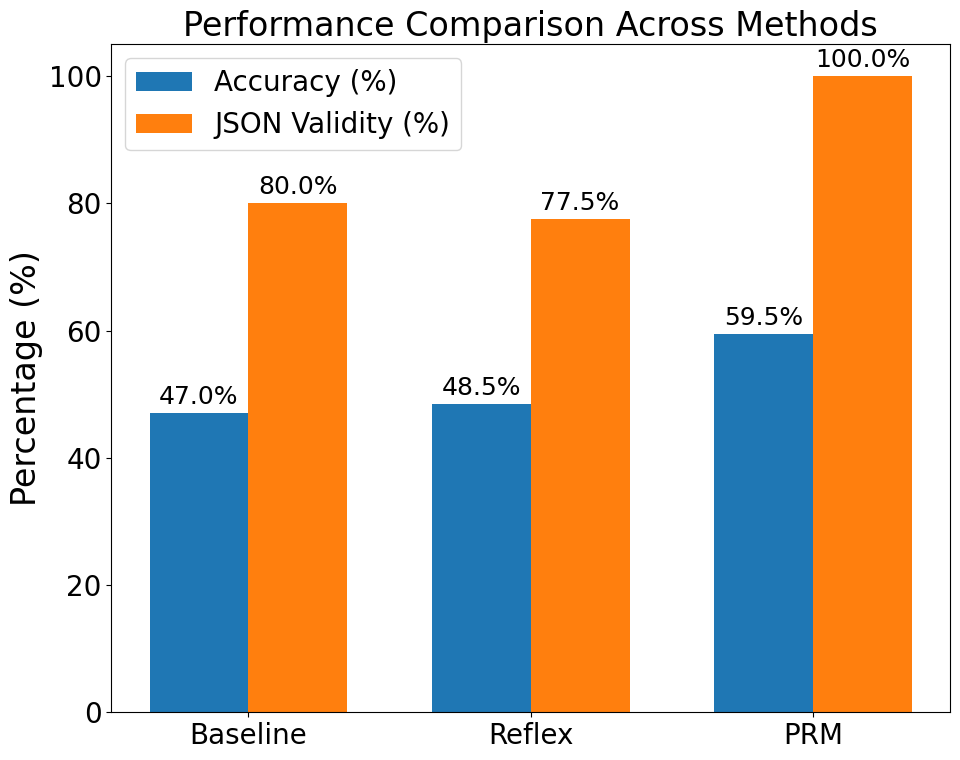

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.size": 20,          # base font size
    "axes.titlesize": 24,     # title
    "axes.labelsize": 24,     # x/y labels
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20
})


methods = ["Baseline", "Reflex", "PRM"]

accuracy = [47.00, 48.50, 59.50]
json_valid = [80.00, 77.50, 100.00]

x = np.arange(len(methods))
width = 0.35


fig, ax = plt.subplots(figsize=(10, 8))

bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy (%)')
bars2 = ax.bar(x + width/2, json_valid, width, label='JSON Validity (%)')


ax.set_ylabel("Percentage (%)")
ax.set_title("Performance Comparison Across Methods")
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f'{height:.1f}%',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom', fontsize=18
        )

plt.tight_layout()
plt.savefig("performance_plot.svg", dpi=300, bbox_inches="tight")
plt.show()


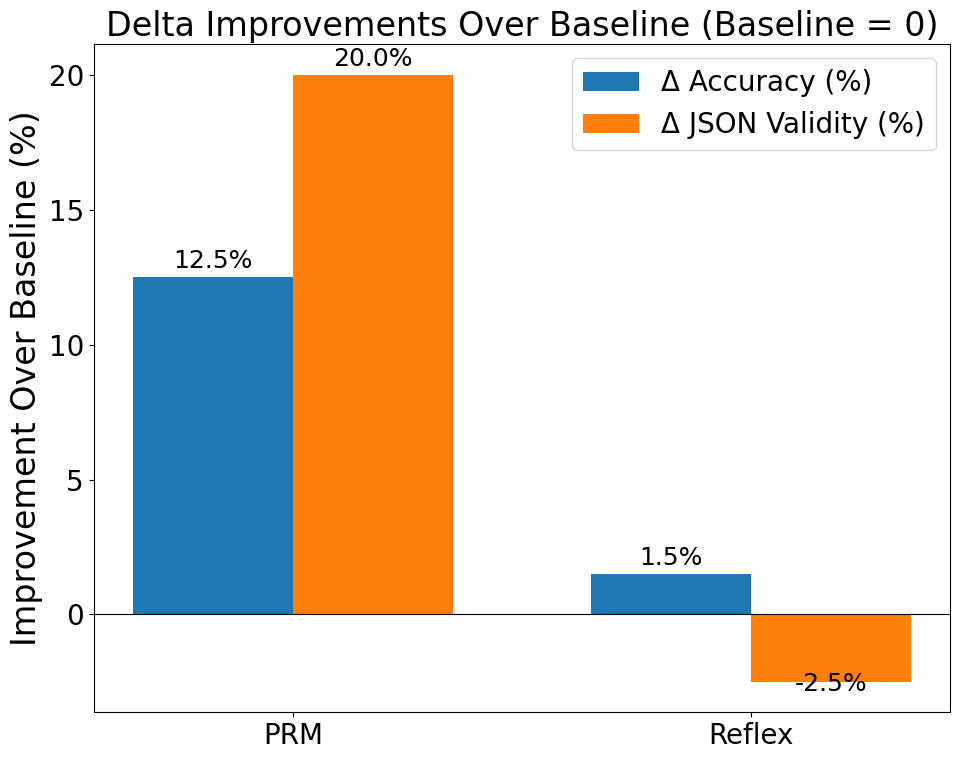

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.size": 20,          # base font size
    "axes.titlesize": 24,     # title
    "axes.labelsize": 24,     # x/y labels
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20
})


baseline_acc = 47.00
baseline_json = 80.00

methods = ["PRM", "Reflex"]

accuracy = [59.50, 48.50]
json_valid = [100.00, 77.50]


delta_acc = [acc - baseline_acc for acc in accuracy]
delta_json = [jv - baseline_json for jv in json_valid]

x = np.arange(len(methods))
width = 0.35


fig, ax = plt.subplots(figsize=(10, 8))

bars1 = ax.bar(x - width/2, delta_acc, width, label='Δ Accuracy (%)')
bars2 = ax.bar(x + width/2, delta_json, width, label='Δ JSON Validity (%)')

ax.axhline(0, color='black', linewidth=0.8)

ax.set_ylabel("Improvement Over Baseline (%)")
ax.set_title("Delta Improvements Over Baseline (Baseline = 0)")
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f'{height:.1f}%',
            xy=(bar.get_x() + bar.get_width()/2, height),
            xytext=(0, 3 if height >= 0 else -10),
            textcoords="offset points",
            ha='center', va='bottom', fontsize = 18
        )

plt.tight_layout()
plt.savefig("delta_plot.svg", dpi=300, bbox_inches="tight")
plt.show()
